## Dow Jones Industrial Average (DJIA) index movement prediction using Daily News from Reddit and past Historical Data

### Name: Aristotelis-Angelos Papadopoulos
### USC ID: 3804-2945-23

In [677]:
# Import the required libraries

import numpy as np
from numpy import nan as Nan
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# In order to supress some warnings
import warnings
warnings.filterwarnings("ignore")

## 1. Import Data and Preprocessing

In [472]:
# Create a dataframe with the stock data
# This dataframe contains the 'Date', the 'Open', 'High', 'Low', 'Close' and the 'Adjusting Close' 
# prices of the stock as well as the volume of the stock from 2008 up to 2016. 
stock_data = pd.read_csv('DJIA_table.csv', sep = ",")

In order to deal with the Reddit news data, we used some preprocessing techniques borrowed from the NLP literature with which, we are able to extract the 'Subjectivity' and the 'Objectivity' of the news as well as the 'Positive', 'Neutral' or 'Negative' sentiment that the news have for the stock price movement. For more details regarding this preprocessing technique, please check the following GitHub [link](https://github.com/AristotelisPap/Stock-Price-Prediction-Model/tree/master/Sentence_Polarity).

In [473]:
# Create a dataframe with the Reddit News as well as the aforementioned extracted features 
news_data = pd.read_csv('combined_stock_data_proc.csv', parse_dates=[0])
del news_data['Unnamed: 0']

Now, I am going to merge the 'Subjectivity', the 'Objectivity', the 'Positive', the 'Neutral' and the 'Negative' feautures of the news_data dataframe with the stock_data dataframe.

In [474]:
# Create a dataframe by merging the headlines and the stock prices dataframe
news_data_sub = news_data.loc[:,["Date", "Subjectivity", "Objectivity", "Positive", "Neutral", "Negative", "Label"]]
dataset = news_data_sub.merge(stock_data, how='inner', on='Date', left_index=True)

Now, at each day, we are going to take into consideration what were the the 'Open', 'High', 'Low' and 'Close' prices of the stock during the past 4 days! Moreover, we will also take into cobsideration what was the movement of the index during those days (whether it increased or decreased). Note that we are going to throw the first 4 data points of the dataset in order to avoid missing values while taking into consideration the prices of the index for the last 4 days! So, let's modify our dataset accordingly! 

In [475]:
# Prices 1 day ago
prices_1_day_ago = dataset.loc[range(1985,0,-1), ["Open", "High", "Low", "Close", "Label"]]

# Prices 2 days ago
prices_2_days_ago = dataset.loc[range(1986,1,-1), ["Open", "High", "Low", "Close", "Label"]]

# Prices 3 days ago
prices_3_days_ago = dataset.loc[range(1987,2,-1), ["Open", "High", "Low", "Close", "Label"]]

# Prices 4 days ago
prices_4_days_ago = dataset.loc[range(1988,3,-1), ["Open", "High", "Low", "Close", "Label"]]

# Now, we can safely delete the first 4 data points of our dataset
dataset = dataset.drop(dataset.index[0:4])

In [476]:
# Now, in order to concatenate the dataframes, we are going to convert
# them into numpy arrays and then we will cocatenate the arrays!

dataset_array = dataset.values
prices_1_day_ago_array = prices_1_day_ago.values
prices_2_days_ago_array = prices_2_days_ago.values
prices_3_days_ago_array = prices_3_days_ago.values
prices_4_days_ago_array = prices_4_days_ago.values

# Now, let's concatenate the arrays
dataset_array = np.concatenate((dataset_array, prices_1_day_ago_array), axis=1)
dataset_array = np.concatenate((dataset_array, prices_2_days_ago_array), axis=1)
dataset_array = np.concatenate((dataset_array, prices_3_days_ago_array), axis=1)
dataset_array = np.concatenate((dataset_array, prices_4_days_ago_array), axis=1)

# Convert the dataset_array into a dataframe
dataset = pd.DataFrame(dataset_array)

In [477]:
# Name the columns of the dataframe
dataset.columns = ['Date', 'Subjectivity', 'Objectivity', 'Positive', 'Neutral', 'Negative', 'Label',
                   'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Open 1 day ago',
                   'High 1 day ago', 'Low 1 day ago', 'Close 1 day ago', 'Movement 1 day ago', 
                   'Open 2 days ago', 'High 2 days ago', 'Low 2 days ago', 'Close 2 days ago',
                   'Movement 2 days ago', 'Open 3 days ago', 'High 3 days ago', 'Low 3 days ago',
                   'Close 3 days ago', 'Movement 3 days ago', 'Open 4 days ago', 'High 4 days ago',
                   'Low 4 days ago', 'Close 4 days ago', 'Movement 4 days ago']

In [478]:
# Now let's do some final steps as preprocessing in our dataset!

# First, we are going to remove the features 'High', 'Low', 'Close', 'Volume', 'Adj Close'
# from each data point since these are values that are not known during the time of
# the prediction. However, we are going to assume the feature 'Open' is known during the
# time of the prediction!
del dataset['High']
del dataset['Low']
del dataset['Close']
del dataset['Volume']
del dataset['Adj Close']

# As a last step, we are going to move the Label into the last column of our dataframe!
cols = list(dataset)
cols.append(cols.pop(cols.index('Label')))
dataset = dataset.ix[:, cols]
dataset

,Date,Subjectivity,Objectivity,Positive,Neutral,Negative,Open,Open 1 day ago,High 1 day ago,Low 1 day ago,...,High 3 days ago,Low 3 days ago,Close 3 days ago,Movement 3 days ago,Open 4 days ago,High 4 days ago,Low 4 days ago,Close 4 days ago,Movement 4 days ago,Label
0,2008-08-14,45.4545,54.5455,36.3636,54.5455,9.09091,11532.1,11632.8,11633.8,11453.3,...,11867.1,11675.5,11782.3,1,11432.1,11760,11388,11734.3,0,1
1,2008-08-15,70,30,10,30,60,11611.2,11532.1,11718.3,11450.9,...,11782.3,11601.5,11642.5,0,11729.7,11867.1,11675.5,11782.3,1,1
2,2008-08-18,100,0,0,0,100,11659.7,11611.2,11709.9,11599.7,...,11633.8,11453.3,11533,0,11781.7,11782.3,11601.5,11642.5,0,0
3,2008-08-19,22.2222,77.7778,22.2222,77.7778,0,11478.1,11659.7,11690.4,11434.1,...,11718.3,11450.9,11615.9,1,11632.8,11633.8,11453.3,11533,0,0
4,2008-08-20,70,30,10,30,60,11345.9,11478.1,11478.2,11318.5,...,11709.9,11599.7,11659.9,1,11532.1,11718.3,11450.9,11615.9,1,1
5,2008-08-21,50,50,20,50,30,11415.2,11345.9,11454.2,11290.6,...,11690.4,11434.1,11479.4,0,11611.2,11709.9,11599.7,11659.9,1,1
6,2008-08-22,50,50,0,50,50,11426.8,11415.2,11476.2,11315.6,...,11478.2,11318.5,11348.5,0,11659.7,11690.4,11434.1,11479.4,0,1
7,2008-08-25,55.5556,44.4444,22.2222,44.4444,33.3333,11626.2,11426.8,11632.1,11426.8,...,11454.2,11290.6,11417.4,1,11478.1,11478.2,11318.5,11348.5,0,0
8,2008-08-26,66.6667,33.3333,0,33.3333,66.6667,11383.6,11626.2,11626.3,11362.6,...,11476.2,11315.6,11430.2,1,11345.9,11454.2,11290.6,11417.4,1,1
9,2008-08-27,30.7692,69.2308,30.7692,69.2308,0,11412.5,11383.6,11436.2,11340.4,...,11632.1,11426.8,11628.1,1,11415.2,11476.2,11315.6,11430.2,1,1


In [479]:
# Now, let us convert the type of our data from object to float such that we will be able to directly use the 
# statistics of each feature later!

dataset['Subjectivity'] = dataset['Subjectivity'].astype(float)
dataset['Objectivity'] = dataset['Objectivity'].astype(float)
dataset['Positive'] = dataset['Positive'].astype(float)
dataset['Neutral'] = dataset['Neutral'].astype(float)
dataset['Negative'] = dataset['Negative'].astype(float)
dataset['Open'] = dataset['Open'].astype(float)
dataset['Open 1 day ago'] = dataset['Open 1 day ago'].astype(float)
dataset['High 1 day ago'] = dataset['High 1 day ago'].astype(float)
dataset['Low 1 day ago'] = dataset['Low 1 day ago'].astype(float)
dataset['Close 1 day ago'] = dataset['Close 1 day ago'].astype(float)
dataset['Movement 1 day ago'] = dataset['Movement 1 day ago'].astype(float)
dataset['Open 2 days ago'] = dataset['Open 2 days ago'].astype(float)
dataset['High 2 days ago'] = dataset['High 2 days ago'].astype(float)
dataset['Low 2 days ago'] = dataset['Low 2 days ago'].astype(float)
dataset['Close 2 days ago'] = dataset['Close 2 days ago'].astype(float)
dataset['Movement 2 days ago'] = dataset['Movement 2 days ago'].astype(float)
dataset['Open 3 days ago'] = dataset['Open 3 days ago'].astype(float)
dataset['High 3 days ago'] = dataset['High 3 days ago'].astype(float)
dataset['Low 3 days ago'] = dataset['Low 3 days ago'].astype(float)
dataset['Close 3 days ago'] = dataset['Close 3 days ago'].astype(float)
dataset['Movement 3 days ago'] = dataset['Movement 3 days ago'].astype(float)
dataset['Open 4 days ago'] = dataset['Open 4 days ago'].astype(float)
dataset['High 4 days ago'] = dataset['High 4 days ago'].astype(float)
dataset['Low 4 days ago'] = dataset['Low 4 days ago'].astype(float)
dataset['Close 4 days ago'] = dataset['Close 4 days ago'].astype(float)
dataset['Movement 4 days ago'] = dataset['Movement 4 days ago'].astype(float)
dataset['Label'] = dataset['Label'].astype(int)


# Now, let's print the description of our dataset, i.e. the statistics of each feature in our dataset!
print(dataset.describe())

       Subjectivity  Objectivity     Positive      Neutral     Negative  \
count   1982.000000  1982.000000  1982.000000  1982.000000  1982.000000   
mean      56.699306    43.300694    19.959309    43.300694    36.739996   
std       21.563572    21.563572    16.382322    21.563572    21.124198   
min        0.000000     0.000000     0.000000     0.000000     0.000000   
25%       40.000000    28.571429     8.333333    28.571429    21.739130   
50%       54.545455    45.454545    18.181818    45.454545    33.333333   
75%       71.428571    60.000000    28.571429    60.000000    50.000000   
max      100.000000   100.000000   100.000000   100.000000   100.000000   

               Open  Open 1 day ago  High 1 day ago  Low 1 day ago  \
count   1985.000000     1985.000000     1985.000000    1985.000000   
mean   13462.773577    13459.604091    13541.682725   13373.390028   
std     3145.385183     3144.056804     3137.105163    3151.148286   
min     6547.009766     6547.009766     6709

## 2. Train, Validation and Test set

As it is also recommended by the Kaggle website ([link](https://www.kaggle.com/aaron7sun/stocknews/home)), we are going to use data from 2008-08-08 to 2014-12-31 as Training Set and Test Set is then the following two years data (from 2015-01-02 to 2016-07-01). Since our data consist of time-series, we are not able to use a Cross-Validation approach. Therefore, we are going to extract some data from the Training set in order to use them as a Validation Set for hyperparameter tuning of our machine learning algorithms. So, finally, we are going to have:

#### Training Set: 2008 - 2013
#### Validation Set: 2014
#### Test Set: 2015 - 2016

In [480]:
training_set = dataset.iloc[0:1355]
validation_set = dataset.iloc[1355:1607]
test_set = dataset.iloc[1607:]

## 3. Machine Learning models

### 3.1. Logistic Regression with L2 regularization

The methodology that I am going to apply will be as follows: I am going to use the validation set in order to pick the best value of the parameter lamda of the regularization. However, I plan to make my algorithm to update its weights every certain number of days such that it can be adapted to new upcoming data. How often the model is going to update its weights, is going to be determined by the validation set!  

In [481]:
# Let's separate the input x from the output y of the training, validation and test sets!
training_x = training_set.loc[:,'Subjectivity':'Movement 4 days ago']
training_y = training_set.loc[:,'Label']
validation_x = validation_set.loc[:,'Subjectivity':'Movement 4 days ago']
validation_y = validation_set.loc[:,'Label']
test_x = test_set.loc[:,'Subjectivity':'Movement 4 days ago']
test_y = test_set.loc[:,'Label']

# Now, let me fill the missing values of the features using the mean of the training data!
# Change the NaN values to the mean value of that column
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    training_x[col] = training_x[col].fillna(training_x[col].mean())
    validation_x[col] = validation_x[col].fillna(training_x[col].mean())
    test_x[col] = test_x[col].fillna(training_x[col].mean())

In [482]:
# Before proceeding to the training of the algorithm, I will first define a function which is 
# going to be used for standardizing the data!

def Preprocessing(train_set, test_set, standardization_method):
    """
    Implements Preprocessing of the data using the requested standardization method.
    
    Arguments:
    train_set -- training data, shape (number of training examples, number of features)
    test_set -- test data, shape (number of test examples, number of features)
    standardization_method -- Can be 1 out of the 3 aforementioned methods
    
    Returns:
    train_set_std -- standardized training data
    test_set_std -- standardized test data
    """
    
    train_set_std = np.zeros((train_set.shape[0], train_set.shape[1]))
    test_set_std = np.zeros((test_set.shape[0], test_set.shape[1]))
    
    if standardization_method == 'standard':
        # Now, I have to standardize my training set such that every column 
        # has zero mean and unit variance!
        mean = np.mean(train_set, axis=0)
        standard_deviation = np.std(train_set, axis=0)
        for i in range (0, train_set.shape[0]):
            for j in range(0, train_set.shape[1]):
                train_set_std[i,j] = (train_set[i,j] - mean[j]) / standard_deviation[j] 
        # Now, I also have to do the standardization to the test set as well,
        # by using the mean and the standard deviation calculated above.
        for i in range (0, test_set.shape[0]):
            for j in range(0, test_set.shape[1]):
                    test_set_std[i,j] = (test_set[i,j] - mean[j]) / standard_deviation[j]
                    
    elif standardization_method == 'log':
        train_set_std = np.log(train_set + 0.1)
        test_set_std = np.log(test_set + 0.1)
        
    elif standardization_method == 'binarize':
        threshold, upper, lower = 0, 1, 0
        train_set_std = np.where(train_set > threshold, upper, lower)
        test_set_std = np.where(test_set > threshold, upper, lower)
        
                    
    return train_set_std, test_set_std

In [483]:
# As it was mentioned before, we are going to use the validation set in order to determine 
# both the best regularization parameter as well as how often the algorithm should
# update its weights according to the new upcoming data! 

# We are going to use 40 different values for C!
C_range = np.logspace(-4, 4, num=40) # C ranges from 10^-4 to 10^4 with a log increment

# The possible update of the weights could happen after 3,5,8,10,13,15,18 or 20 days!
upd_days = [3,5,8,10,13,15,18,20]

# In this list, I will save the different Validation errors that I am going to compare.
ave_Validation_errors = [] 

for C1 in C_range:
    for days in upd_days:
        training_x = training_set.loc[:,'Subjectivity':'Movement 4 days ago']
        training_y = training_set.loc[:,'Label']
        validation_x = validation_set.loc[:,'Subjectivity':'Movement 4 days ago']
        validation_y = validation_set.loc[:,'Label']
        validation_y = validation_y.values # In order to convert it into a numpy array
        
        # Now, let me fill the missing values of the features using their mean!
        # Change the NaN values to the mean value of that column
        nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
        for col in nan_list:
            training_x[col] = training_x[col].fillna(training_x[col].mean())
            validation_x[col] = validation_x[col].fillna(training_x[col].mean())
        
        # Standardize the data to have zero mean and unit variance
        training_x, validation_x = Preprocessing(training_x.values, validation_x.values, 'standard')
        
        # Now, I will fit my Logistic Regression model in the Training set!
        model = LogisticRegression(penalty='l2', C=C1)
        model.fit(training_x, training_y)
        
        # Now, in the validation setting, I will add data from the validation set
        # into the training set every certain number of days in order to find
        # how often the model should update its weights!
        
        # First, I will create an empty list where I am going to add the prediction errors
        # after each certain number of days!
        indiv_errors = []
        
        for i in range(0, len(validation_x)):
            if (i+1) % days == 0:
                # Evaluate the performance on the datastream of the validation set
                # and save it to the list!
                datastream_x = validation_x[0:days,:]
                datastream_y = validation_y[0:days]
                indiv_errors.append(1 - model.score(datastream_x, datastream_y))
                # Add the datastream to the training set
                training_x = np.append(training_x, validation_x[0:days,:], axis=0)
                training_y = np.append(training_y, validation_y[0:days], axis=0)
                # Delete the datastream from the validation set
                for i in range(0, days):
                    validation_x = np.delete(validation_x,(0),axis=0)
                    validation_y = np.delete(validation_y,(0),axis=0)
                # Retrain the model on the updated training set
                model.fit(training_x, training_y)
                
        # Calculate the average error of the indiv_errors list and add it
        # to the ave_Validation_errors list!
        ave_Validation_errors.append(sum(indiv_errors) / len(indiv_errors))
        
# Convert the ave_Validation_errors list into a numpy array
Array_valid = np.asarray(ave_Validation_errors)
Array_valid = Array_valid.reshape(40,8) # Indexes are (C, upd_days)
# Take the indexes of the minimum element of the Array_valid
ind_arr_val = np.unravel_index(np.argmin(Array_valid, axis=None), Array_valid.shape)

print("The minimum Validation Error happens for : C =", C_range[ind_arr_val[0]])
print("The algorithm should update its weights every", upd_days[ind_arr_val[1]], "days")
print("The Validation Error is: ", min(ave_Validation_errors))

The minimum Validation Error happens for : C = 2424.462017082326
The algorithm should update its weights every 5 days
The Validation Error is:  0.3719999999999997


In [485]:
# Now, we know what should be the regularization parameter C as well as
# how often the algorithm should update its weights. So, we can evaluate
# the performance of our algorithm!

# At first, we re going to concatenate the training and the validation sets!
frames = [training_set, validation_set]
final_training = pd.concat(frames)

# Let's separate the input x from the output y of the full training and test sets!
training_x = final_training.loc[:,'Subjectivity':'Movement 4 days ago']
training_y = final_training.loc[:,'Label']
test_x = test_set.loc[:,'Subjectivity':'Movement 4 days ago']
test_y = test_set.loc[:,'Label']
test_y = test_y.values # In order to convert it into a numpy array

# Now, let me fill the missing values of the features using their mean!
# Change the NaN values to the mean value of that column
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    training_x[col] = training_x[col].fillna(training_x[col].mean())
    test_x[col] = test_x[col].fillna(training_x[col].mean())

# Standardize the data to have zero mean and unit variance
training_x, test_x = Preprocessing(training_x.values, test_x.values, 'standard')

# Now, I will refit my Logistic Regression model using the optimum C calculated by Validation.
model = LogisticRegression(penalty='l2', C= C_range[ind_arr_val[0]])
model.fit(training_x, training_y)

# Now, in order to evaluate my algorithm on the test set, I will make the
# model to update its weights every 5 days!
# First, I will create an empty list where I am going to add the prediction errors
# after each certain number of days!
indiv_errors = []
        
for i in range(0, len(test_x)):
    if (i+1) % upd_days[ind_arr_val[1]] == 0:
        # Evaluate the performance on the datastream of the test set
        # and save it to the list!
        datastream_x = test_x[0:upd_days[ind_arr_val[1]],:]
        datastream_y = test_y[0:upd_days[ind_arr_val[1]]]
        indiv_errors.append(1 - model.score(datastream_x, datastream_y))
        # Add the datastream to the training set
        training_x = np.append(training_x, test_x[0:upd_days[ind_arr_val[1]],:], axis=0)
        training_y = np.append(training_y, test_y[0:upd_days[ind_arr_val[1]]], axis=0)
        # Delete the datastream from the test set
        for i in range(0, upd_days[ind_arr_val[1]]):
            test_x = np.delete(test_x,(0),axis=0)
            test_y = np.delete(test_y,(0),axis=0)
        # Retrain the model on the updated training set
        model.fit(training_x, training_y)

# Calculate the average error of the indiv_errors list.
# This will be the final test error!
final_test_error = sum(indiv_errors) / len(indiv_errors)


print("The Test Error is: ", final_test_error)

The Test Error is:  0.3733333333333331


### 3.2. Random Forest

The methodology that I am going to apply will be as follows: I am going to use the validation set in order to pick the appropriate number of trees that the forest is going to contain as well as the minimum number of samples required to split an internal node so that we will able to control possible overfitting problems. Moreover, I also plan to make my algorithm to update its weights every certain number of days such that it can be adapted to new upcoming data. How often the model is going to update its weights, is going to be determined by the validation set! 

In [661]:
# We are going to use 10 different values for the number of trees!
num_trees = list(range(20,210,20)) # num_trees ranges from 20 to 200 with a step 20

# We are going to use 10 different values for the minimum number of 
# samples required to split an internal node! 
min_num_samples = list(range(2,21,2)) # min_num_samples ranges from 2 to 20 with a step 2

# The possible update of the weights could happen after 5,10,15 or 20 days!
upd_days = [5,10,15,20]

# In this list, I will save the different Validation errors that I am going to compare.
ave_Validation_errors = [] 

for trees in num_trees:
    for samples in min_num_samples:
        for days in upd_days:
            training_x = training_set.loc[:,'Subjectivity':'Movement 4 days ago']
            training_y = training_set.loc[:,'Label']
            validation_x = validation_set.loc[:,'Subjectivity':'Movement 4 days ago']
            validation_y = validation_set.loc[:,'Label']
            validation_y = validation_y.values # In order to convert it into a numpy array

            # Now, let me fill the missing values of the features using their mean!
            # Change the NaN values to the mean value of that column
            nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
            for col in nan_list:
                training_x[col] = training_x[col].fillna(training_x[col].mean())
                validation_x[col] = validation_x[col].fillna(training_x[col].mean())

            # Standardize the data to have zero mean and unit variance
            training_x, validation_x = Preprocessing(training_x.values, validation_x.values, 'standard')

            # Now, I will fit the Random Forest classifier in the Training set!
            model = RandomForestClassifier(n_estimators=trees, max_depth=3, criterion = 'gini', 
                                           min_samples_split=samples,
                                           bootstrap=True)
            model.fit(training_x, training_y)

            # Now, in the validation setting, I will add data from the validation set
            # into the training set every certain number of days in order to find
            # how often the model should update its weights!

            # First, I will create an empty list where I am going to add the prediction errors
            # after each certain number of days!
            indiv_errors = []

            for i in range(0, len(validation_x)):
                if (i+1) % days == 0:
                    # Evaluate the performance on the datastream of the validation set
                    # and save it to the list!
                    datastream_x = validation_x[0:days,:]
                    datastream_y = validation_y[0:days]
                    indiv_errors.append(1 - model.score(datastream_x, datastream_y))
                    # Add the datastream to the training set
                    training_x = np.append(training_x, validation_x[0:days,:], axis=0)
                    training_y = np.append(training_y, validation_y[0:days], axis=0)
                    # Delete the datastream from the validation set
                    for i in range(0, days):
                        validation_x = np.delete(validation_x,(0),axis=0)
                        validation_y = np.delete(validation_y,(0),axis=0)
                    # Retrain the model on the updated training set
                    model.fit(training_x, training_y)

            # Calculate the average error of the indiv_errors list and add it
            # to the ave_Validation_errors list!
            ave_Validation_errors.append(sum(indiv_errors) / len(indiv_errors))
        
# Convert the ave_Validation_errors list into a numpy array
Array_valid = np.asarray(ave_Validation_errors)
Array_valid = Array_valid.reshape(10,10,4) # Indexes are (num_trees, min_num_samples, upd_days)
# Take the indexes of the minimum element of the Array_valid
ind_arr_val = np.unravel_index(np.argmin(Array_valid, axis=None), Array_valid.shape)

print("The minimum Validation Error happens for : number of trees =", num_trees[ind_arr_val[0]])
print("The minimum Validation Error happens for : minimum number of samples =", min_num_samples[ind_arr_val[1]])
print("The algorithm should update its weights every", upd_days[ind_arr_val[2]], "days")
print("The Validation Error is: ", min(ave_Validation_errors))

The minimum Validation Error happens for : number of trees = 40
The minimum Validation Error happens for : minimum number of samples = 6
The algorithm should update its weights every 5 days
The Validation Error is:  0.4439999999999998


In [669]:
# Now, we know what should be the best number of trees that the forest should contain
# as well as minimum number of 
# samples required to split an internal node!
# Moreover, we know how often the algorithm should update its weights. 
# So, we can evaluate the performance of our algorithm!

# At first, we re going to concatenate the training and the validation sets!
frames = [training_set, validation_set]
final_training = pd.concat(frames)

# Let's separate the input x from the output y of the full training and test sets!
training_x = final_training.loc[:,'Subjectivity':'Movement 4 days ago']
training_y = final_training.loc[:,'Label']
test_x = test_set.loc[:,'Subjectivity':'Movement 4 days ago']
test_y = test_set.loc[:,'Label']
test_y = test_y.values # In order to convert it into a numpy array

# Now, let me fill the missing values of the features using their mean!
# Change the NaN values to the mean value of that column
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    training_x[col] = training_x[col].fillna(training_x[col].mean())
    test_x[col] = test_x[col].fillna(training_x[col].mean())

# Standardize the data to have zero mean and unit variance
training_x, test_x = Preprocessing(training_x.values, test_x.values, 'standard')

# Now, I will refit the Random Forest Classifier using the optimum parameters calculated by Validation.
model = model = RandomForestClassifier(n_estimators=num_trees[ind_arr_val[0]], 
                                       min_samples_split=min_num_samples[ind_arr_val[1]],
                                       bootstrap=True)
model.fit(training_x, training_y)

# Now, in order to evaluate my algorithm on the test set, I will make the
# model to update its weights every 5 days!
# First, I will create an empty list where I am going to add the prediction errors
# after each certain number of days!
indiv_errors = []
        
for i in range(0, len(test_x)):
    if (i+1) % upd_days[ind_arr_val[2]] == 0:
        # Evaluate the performance on the datastream of the test set
        # and save it to the list!
        datastream_x = test_x[0:upd_days[ind_arr_val[2]],:]
        datastream_y = test_y[0:upd_days[ind_arr_val[2]]]
        indiv_errors.append(1 - model.score(datastream_x, datastream_y))
        # Add the datastream to the training set
        training_x = np.append(training_x, test_x[0:upd_days[ind_arr_val[2]],:], axis=0)
        training_y = np.append(training_y, test_y[0:upd_days[ind_arr_val[2]]], axis=0)
        # Delete the datastream from the test set
        for i in range(0, upd_days[ind_arr_val[2]]):
            test_x = np.delete(test_x,(0),axis=0)
            test_y = np.delete(test_y,(0),axis=0)
        # Retrain the model on the updated training set
        model.fit(training_x, training_y)

# Calculate the average error of the indiv_errors list.
# This will be the final test error!
final_test_error = sum(indiv_errors) / len(indiv_errors)


print("The Test Error is: ", final_test_error)

The Test Error is:  0.46666666666666645


### 3.3. AdaBoost

The methodology that I am going to apply will be as follows: I am going to use the validation set in order to pick the appropriate number of estimators at which boosting is terminated as well as the learning rate so that we will able to control possible overfitting problems. Moreover, I also plan to make my algorithm to update its weights every certain number of days such that it can be adapted to new upcoming data. How often the model is going to update its weights, is going to be determined by the validation set! 

In [671]:
# We are going to use 10 different values for the number of estimators!
num_estim = list(range(10,110,10)) # num_estim ranges from 10 to 100 with a step 10

# We are going to use 7 different values for the learning rate! 
learn_rates = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100] # learn_rates ranges from 10^-4 to 10^2

# The possible update of the weights could happen after 5,10,15 or 20 days!
upd_days = [5,10,15,20]

# In this list, I will save the different Validation errors that I am going to compare.
ave_Validation_errors = [] 


for estim in num_estim:
    for rates in learn_rates:
        for days in upd_days:
            training_x = training_set.loc[:,'Subjectivity':'Movement 4 days ago']
            training_y = training_set.loc[:,'Label']
            validation_x = validation_set.loc[:,'Subjectivity':'Movement 4 days ago']
            validation_y = validation_set.loc[:,'Label']
            validation_y = validation_y.values # In order to convert it into a numpy array

            # Now, let me fill the missing values of the features using their mean!
            # Change the NaN values to the mean value of that column
            nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
            for col in nan_list:
                training_x[col] = training_x[col].fillna(training_x[col].mean())
                validation_x[col] = validation_x[col].fillna(training_x[col].mean())

            # Standardize the data to have zero mean and unit variance
            training_x, validation_x = Preprocessing(training_x.values, validation_x.values, 'standard')

            # Now, I will fit the AdaBoost classifier in the Training set!
            model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), 
                                       n_estimators=estim, learning_rate=rates)
            model.fit(training_x, training_y)

            # Now, in the validation setting, I will add data from the validation set
            # into the training set every certain number of days in order to find
            # how often the model should update its weights!

            # First, I will create an empty list where I am going to add the prediction errors
            # after each certain number of days!
            indiv_errors = []

            for i in range(0, len(validation_x)):
                if (i+1) % days == 0:
                    # Evaluate the performance on the datastream of the validation set
                    # and save it to the list!
                    datastream_x = validation_x[0:days,:]
                    datastream_y = validation_y[0:days]
                    indiv_errors.append(1 - model.score(datastream_x, datastream_y))
                    # Add the datastream to the training set
                    training_x = np.append(training_x, validation_x[0:days,:], axis=0)
                    training_y = np.append(training_y, validation_y[0:days], axis=0)
                    # Delete the datastream from the validation set
                    for i in range(0, days):
                        validation_x = np.delete(validation_x,(0),axis=0)
                        validation_y = np.delete(validation_y,(0),axis=0)
                    # Retrain the model on the updated training set
                    model.fit(training_x, training_y)

            # Calculate the average error of the indiv_errors list and add it
            # to the ave_Validation_errors list!
            ave_Validation_errors.append(sum(indiv_errors) / len(indiv_errors))
        
# Convert the ave_Validation_errors list into a numpy array
Array_valid = np.asarray(ave_Validation_errors)
Array_valid = Array_valid.reshape(10,7,4) # Indexes are (num_estim, learn_rates, upd_days)
# Take the indexes of the minimum element of the Array_valid
ind_arr_val_ada = np.unravel_index(np.argmin(Array_valid, axis=None), Array_valid.shape)

print("The minimum Validation Error happens for : number of estimators =", num_estim[ind_arr_val_ada[0]])
print("The minimum Validation Error happens for : learning rate =", learn_rates[ind_arr_val_ada[1]])
print("The algorithm should update its weights every", upd_days[ind_arr_val_ada[2]], "days")
print("The Validation Error is: ", min(ave_Validation_errors))

The minimum Validation Error happens for : number of estimators = 20
The minimum Validation Error happens for : learning rate = 0.001
The algorithm should update its weights every 5 days
The Validation Error is:  0.44399999999999984


In [675]:
# Now, we know what should be the best number of estimators at which boosting
# is terminated as well as the best learning rate!
# Moreover, we know how often the algorithm should update its weights. 
# So, we can evaluate the performance of our algorithm!

# At first, we re going to concatenate the training and the validation sets!
frames = [training_set, validation_set]
final_training = pd.concat(frames)

# Let's separate the input x from the output y of the full training and test sets!
training_x = final_training.loc[:,'Subjectivity':'Movement 4 days ago']
training_y = final_training.loc[:,'Label']
test_x = test_set.loc[:,'Subjectivity':'Movement 4 days ago']
test_y = test_set.loc[:,'Label']
test_y = test_y.values # In order to convert it into a numpy array

# Now, let me fill the missing values of the features using their mean!
# Change the NaN values to the mean value of that column
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    training_x[col] = training_x[col].fillna(training_x[col].mean())
    test_x[col] = test_x[col].fillna(training_x[col].mean())

# Standardize the data to have zero mean and unit variance
training_x, test_x = Preprocessing(training_x.values, test_x.values, 'standard')

# Now, I will refit the AdaBoost Classifier using the optimum parameters calculated by Validation.
model = model = AdaBoostClassifier(n_estimators=num_estim[ind_arr_val_ada[0]], 
                                   learning_rate=learn_rates[ind_arr_val_ada[1]])
model.fit(training_x, training_y)

# Now, in order to evaluate my algorithm on the test set, I will make the
# model to update its weights every 5 days!
# First, I will create an empty list where I am going to add the prediction errors
# after each certain number of days!
indiv_errors = []
        
for i in range(0, len(test_x)):
    if (i+1) % upd_days[ind_arr_val_ada[2]] == 0:
        # Evaluate the performance on the datastream of the test set
        # and save it to the list!
        datastream_x = test_x[0:upd_days[ind_arr_val_ada[2]],:]
        datastream_y = test_y[0:upd_days[ind_arr_val_ada[2]]]
        indiv_errors.append(1 - model.score(datastream_x, datastream_y))
        # Add the datastream to the training set
        training_x = np.append(training_x, test_x[0:upd_days[ind_arr_val_ada[2]],:], axis=0)
        training_y = np.append(training_y, test_y[0:upd_days[ind_arr_val_ada[2]]], axis=0)
        # Delete the datastream from the test set
        for i in range(0, upd_days[ind_arr_val_ada[2]]):
            test_x = np.delete(test_x,(0),axis=0)
            test_y = np.delete(test_y,(0),axis=0)
        # Retrain the model on the updated training set
        model.fit(training_x, training_y)

# Calculate the average error of the indiv_errors list.
# This will be the final test error!
final_test_error = sum(indiv_errors) / len(indiv_errors)


print("The Test Error is: ", final_test_error)

The Test Error is:  0.4906666666666664


### 3.4. Support Vector Machines

### 3.4.1. Support Vector Machines with Linear Kernel

The methodology that I am going to apply will be as follows: I am going to use the validation set in order to pick the appropriate value for the penalty parameter C of the error term. Moreover, it should be mentioned that I do not plan to make my algorithm to update its weights every certain number of days as I did in the previous cases, since the Support Vector Machines algorithm is general slow during the training process!

In [859]:
# We are going to use 8 different values for the parameter C!
C_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 
           100, 1000] # C ranges from 10^-4 to 10^3 with a log increment

# In this list, I will save the different Validation errors that I am going to compare.
ave_Validation_errors = [] 

training_x = training_set.loc[:,'Subjectivity':'Movement 4 days ago']
training_y = training_set.loc[:,'Label']
validation_x = validation_set.loc[:,'Subjectivity':'Movement 4 days ago']
validation_y = validation_set.loc[:,'Label']
validation_y = validation_y.values # In order to convert it into a numpy array

# Now, let me fill the missing values of the features using their mean!
# Change the NaN values to the mean value of that column
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    training_x[col] = training_x[col].fillna(training_x[col].mean())
    validation_x[col] = validation_x[col].fillna(training_x[col].mean())

# Standardize the data to have zero mean and unit variance
training_x, validation_x = Preprocessing(training_x.values, validation_x.values, 'standard')

for C1 in C_range:
    # Now, I will fit the Linear SVM classifier in the Training set!
    model = SVC(kernel="linear", C=C1)
    model.fit(training_x, training_y)

    # Calculate the error on the Validation set and 
    # add it to the ave_Validation_errors list!
    ave_Validation_errors.append(1 - model.score(validation_x, validation_y))
        
# Convert the ave_Validation_errors list into a numpy array
Array_valid = np.asarray(ave_Validation_errors)
Array_valid = Array_valid.reshape(8,1) # Indexes are (C, 1)
# Take the indexes of the minimum element of the Array_valid
ind_arr_val_svm_lin = np.unravel_index(np.argmin(Array_valid, axis=None), Array_valid.shape)

print("The minimum Validation Error happens for : C =", C_range[ind_arr_val_svm_lin[0]])
print("The Validation Error is: ", min(ave_Validation_errors))

The minimum Validation Error happens for : C = 1000
The Validation Error is:  0.44047619047619047


In [861]:
# Now, we know what should be the best value for the penalty parameter C of the error term!
# Moreover, we know how often the algorithm should update its weights. 
# So, we can evaluate the performance of our algorithm!

# At first, we re going to concatenate the training and the validation sets!
frames = [training_set, validation_set]
final_training = pd.concat(frames)

# Let's separate the input x from the output y of the full training and test sets!
training_x = final_training.loc[:,'Subjectivity':'Movement 4 days ago']
training_y = final_training.loc[:,'Label']
test_x = test_set.loc[:,'Subjectivity':'Movement 4 days ago']
test_y = test_set.loc[:,'Label']
test_y = test_y.values # In order to convert it into a numpy array

# Now, let me fill the missing values of the features using their mean!
# Change the NaN values to the mean value of that column
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    training_x[col] = training_x[col].fillna(training_x[col].mean())
    test_x[col] = test_x[col].fillna(training_x[col].mean())

# Standardize the data to have zero mean and unit variance
training_x, test_x = Preprocessing(training_x.values, test_x.values, 'standard')

# Now, I will refit the Linear SVM Classifier using the optimum parameter C calculated by Validation.
model = SVC(kernel="linear", C=C_range[ind_arr_val_svm_lin[0]])
model.fit(training_x, training_y)

print("The Test Error is: ", 1 - model.score(test_x, test_y))

The Test Error is:  0.4021164021164021


### 3.4.2. Support Vector Machines with Gaussian Kernel

The methodology that I am going to apply will be as follows: I am going to use the validation set in order to pick the appropriate value for the penalty parameter C of the error term as well as the best value for the parameter gamma of the Gaussian kernel. Moreover, I also plan to make my algorithm to update its weights every certain number of days such that it can be adapted to new upcoming data. How often the model is going to update its weights, is going to be determined by the validation set!

In [ ]:
# We are going to use 10 different values for the parameter C!
C_range = np.logspace(-3, 6, num=10) # C ranges from 10^-3 to 10^6 with a log increment 

# We are going to use 20 different values for the parameter gamma of the Gaussian kernel! 
gamma_range = np.linspace(0.1, 4, 20) # gamma ranges from 0.1 to 4 with linear increment

# The possible update of the weights could happen after 5,10,15 or 20 days!
upd_days = [5,10,15,20]

# In this list, I will save the different Validation errors that I am going to compare.
ave_Validation_errors = [] 


for C1 in C_range:
    for gamm in gamma_range:
        for days in upd_days:
            training_x = training_set.loc[:,'Subjectivity':'Movement 4 days ago']
            training_y = training_set.loc[:,'Label']
            validation_x = validation_set.loc[:,'Subjectivity':'Movement 4 days ago']
            validation_y = validation_set.loc[:,'Label']
            validation_y = validation_y.values # In order to convert it into a numpy array

            # Now, let me fill the missing values of the features using their mean!
            # Change the NaN values to the mean value of that column
            nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
            for col in nan_list:
                training_x[col] = training_x[col].fillna(training_x[col].mean())
                validation_x[col] = validation_x[col].fillna(training_x[col].mean())

            # Standardize the data to have zero mean and unit variance
            training_x, validation_x = Preprocessing(training_x.values, validation_x.values, 'standard')

            # Now, I will fit the SVM classifier with Gaussian kernel in the Training set!
            model = SVC(C=C1, kernel='rbf', gamma=gamm)
            model.fit(training_x, training_y)

            # Now, in the validation setting, I will add data from the validation set
            # into the training set every certain number of days in order to find
            # how often the model should update its weights!

            # First, I will create an empty list where I am going to add the prediction errors
            # after each certain number of days!
            indiv_errors = []

            for i in range(0, len(validation_x)):
                if (i+1) % days == 0:
                    # Evaluate the performance on the datastream of the validation set
                    # and save it to the list!
                    datastream_x = validation_x[0:days,:]
                    datastream_y = validation_y[0:days]
                    indiv_errors.append(1 - model.score(datastream_x, datastream_y))
                    # Add the datastream to the training set
                    training_x = np.append(training_x, validation_x[0:days,:], axis=0)
                    training_y = np.append(training_y, validation_y[0:days], axis=0)
                    # Delete the datastream from the validation set
                    for i in range(0, days):
                        validation_x = np.delete(validation_x,(0),axis=0)
                        validation_y = np.delete(validation_y,(0),axis=0)
                    # Retrain the model on the updated training set
                    model.fit(training_x, training_y)

            # Calculate the average error of the indiv_errors list and add it
            # to the ave_Validation_errors list!
            ave_Validation_errors.append(sum(indiv_errors) / len(indiv_errors))
        
# Convert the ave_Validation_errors list into a numpy array
Array_valid = np.asarray(ave_Validation_errors)
Array_valid = Array_valid.reshape(10,20,4) # Indexes are (C, gamma, upd_days)
# Take the indexes of the minimum element of the Array_valid
ind_arr_val_svm_rbf = np.unravel_index(np.argmin(Array_valid, axis=None), Array_valid.shape)

print("The minimum Validation Error happens for : C =", C_range[ind_arr_val_svm_rbf[0]])
print("The minimum Validation Error happens for : gamma =", gamma_range[ind_arr_val_svm_rbf[1]])
print("The algorithm should update its weights every", upd_days[ind_arr_val_svm_rbf[2]], "days")
print("The Validation Error is: ", min(ave_Validation_errors))

In [ ]:
# Now, we know what should be the best value for the penalty parameter C of the error term
# as well as the best value for the parameter gamma of the Gaussian kernel!
# Moreover, we know how often the algorithm should update its weights. 
# So, we can evaluate the performance of our algorithm!

# At first, we re going to concatenate the training and the validation sets!
frames = [training_set, validation_set]
final_training = pd.concat(frames)

# Let's separate the input x from the output y of the full training and test sets!
training_x = final_training.loc[:,'Subjectivity':'Movement 4 days ago']
training_y = final_training.loc[:,'Label']
test_x = test_set.loc[:,'Subjectivity':'Movement 4 days ago']
test_y = test_set.loc[:,'Label']
test_y = test_y.values # In order to convert it into a numpy array

# Now, let me fill the missing values of the features using their mean!
# Change the NaN values to the mean value of that column
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    training_x[col] = training_x[col].fillna(training_x[col].mean())
    test_x[col] = test_x[col].fillna(training_x[col].mean())

# Standardize the data to have zero mean and unit variance
training_x, test_x = Preprocessing(training_x.values, test_x.values, 'standard')

# Now, I will refit the SVM Classifier with Gaussian kernel
# using the optimum parameters C and gamma calculated by Validation.
model = SVC(C=C_range[ind_arr_val_svm_rbf[0]], kernel='rbf', gamma=gamma_range[ind_arr_val_svm_rbf[1]])
model.fit(training_x, training_y)

# Now, in order to evaluate my algorithm on the test set, I will make the
# model to update its weights every 5 days!
# First, I will create an empty list where I am going to add the prediction errors
# after each certain number of days!
indiv_errors = []
        
for i in range(0, len(test_x)):
    if (i+1) % upd_days[ind_arr_val_svm_rbf[2]] == 0:
        # Evaluate the performance on the datastream of the test set
        # and save it to the list!
        datastream_x = test_x[0:upd_days[ind_arr_val_svm_rbf[2]],:]
        datastream_y = test_y[0:upd_days[ind_arr_val_svm_rbf[2]]]
        indiv_errors.append(1 - model.score(datastream_x, datastream_y))
        # Add the datastream to the training set
        training_x = np.append(training_x, test_x[0:upd_days[ind_arr_val_svm_rbf[2]],:], axis=0)
        training_y = np.append(training_y, test_y[0:upd_days[ind_arr_val_svm_rbf[2]]], axis=0)
        # Delete the datastream from the test set
        for i in range(0, upd_days[ind_arr_val_svm_rbf[2]]):
            test_x = np.delete(test_x,(0),axis=0)
            test_y = np.delete(test_y,(0),axis=0)
        # Retrain the model on the updated training set
        model.fit(training_x, training_y)

# Calculate the average error of the indiv_errors list.
# This will be the final test error!
final_test_error = sum(indiv_errors) / len(indiv_errors)


print("The Test Error is: ", final_test_error)

## 4. Other Evaluation Metrics (ROC Curve, AUC)

### 4.1. Logistic Regression

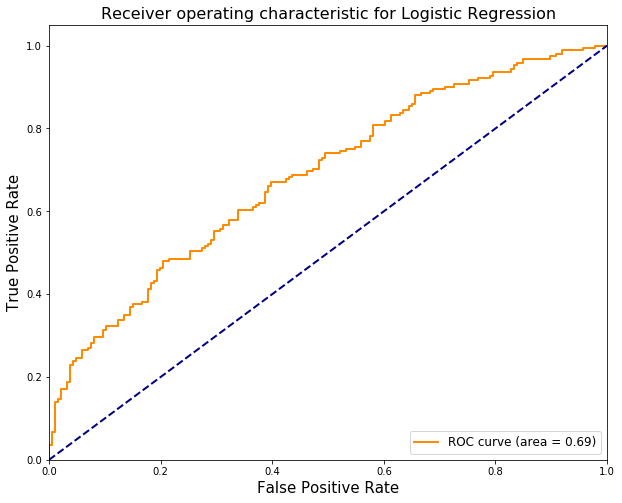

In [758]:
# At first, we re going to concatenate the training and the validation sets!
frames = [training_set, validation_set]
final_training = pd.concat(frames)

# Let's separate the input x from the output y of the full training and test sets!
training_x = final_training.loc[:,'Subjectivity':'Movement 4 days ago']
training_y = final_training.loc[:,'Label']
test_x = test_set.loc[:,'Subjectivity':'Movement 4 days ago']
test_y = test_set.loc[:,'Label']
test_y = test_y.values # In order to convert it into a numpy array

# Now, let me fill the missing values of the features using their mean!
# Change the NaN values to the mean value of that column
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    training_x[col] = training_x[col].fillna(training_x[col].mean())
    test_x[col] = test_x[col].fillna(training_x[col].mean())

# Standardize the data to have zero mean and unit variance
training_x, test_x = Preprocessing(training_x.values, test_x.values, 'standard')

model = LogisticRegression(penalty='l2', C= 2424.46)


# First, I will create an empty list where I am going to add the prediction scores
# after each certain number of days!
indiv_scores = []
        
for i in range(0, len(test_x)):
    if (i+1) % 5 == 0:
        # Evaluate the performance on the datastream of the test set
        # and save it to the list!
        datastream_x = test_x[0:5,:]
        datastream_y = test_y[0:5]
        indiv_scores.append(model.fit(training_x, training_y).decision_function(datastream_x))
        # Add the datastream to the training set
        training_x = np.append(training_x, test_x[0:5,:], axis=0)
        training_y = np.append(training_y, test_y[0:5], axis=0)
        # Delete the datastream from the test set
        for i in range(0, 5):
            test_x = np.delete(test_x,(0),axis=0)
            test_y = np.delete(test_y,(0),axis=0)

      
# Convert the list indiv_scores into a numpy array
y_score = np.asarray(indiv_scores)                                               
y_score = y_score.reshape(375)

# There are still 3 samples left on the test set!
indiv_scores = []
indiv_scores.append(model.fit(training_x, training_y).decision_function(test_x))
indiv_scores = np.asarray(indiv_scores)
indiv_scores = indiv_scores.reshape(3)

# Concatenate the 375 prediction scores with the rest 3 scores!
y_score = np.concatenate((y_score,indiv_scores),axis=None)


# Redefine the test set in its initial form
test_y = test_set.loc[:,'Label']
test_y = test_y.values # In order to convert it into a numpy array


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(test_y[:], y_score[:])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver operating characteristic for Logistic Regression',fontsize=16)
plt.legend(loc="lower right",fontsize=12)
plt.show()

### 4.2. Random Forest

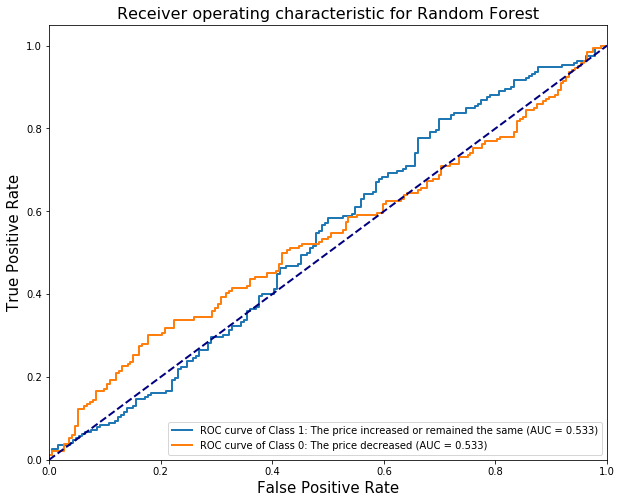

In [854]:
# At first, we re going to concatenate the training and the validation sets!
frames = [training_set, validation_set]
final_training = pd.concat(frames)

# Let's separate the input x from the output y of the full training and test sets!
training_x = final_training.loc[:,'Subjectivity':'Movement 4 days ago']
training_y = final_training.loc[:,'Label']
test_x = test_set.loc[:,'Subjectivity':'Movement 4 days ago']
test_y = test_set.loc[:,'Label']
test_y = test_y.values # In order to convert it into a numpy array

# Now, let me fill the missing values of the features using their mean!
# Change the NaN values to the mean value of that column
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    training_x[col] = training_x[col].fillna(training_x[col].mean())
    test_x[col] = test_x[col].fillna(training_x[col].mean())

# Standardize the data to have zero mean and unit variance
training_x, test_x = Preprocessing(training_x.values, test_x.values, 'standard')

model = RandomForestClassifier(n_estimators=40, max_depth=3, criterion = 'gini', 
                                           min_samples_split=6,
                                           bootstrap=True)


# First, I will create an empty list where I am going to add the prediction scores
# after each certain number of days!
indiv_scores = []
        
for i in range(0, len(test_x)):
    if (i+1) % 5 == 0:
        # Evaluate the performance on the datastream of the test set
        # and save it to the list!
        datastream_x = test_x[0:5,:]
        datastream_y = test_y[0:5]
        indiv_scores.append(model.fit(training_x, training_y).predict_proba(datastream_x))
        # Add the datastream to the training set
        training_x = np.append(training_x, test_x[0:5,:], axis=0)
        training_y = np.append(training_y, test_y[0:5], axis=0)
        # Delete the datastream from the test set
        for i in range(0, 5):
            test_x = np.delete(test_x,(0),axis=0)
            test_y = np.delete(test_y,(0),axis=0)

      
# Convert the list indiv_scores into a numpy array
y_score = np.asarray(indiv_scores)                                               
y_score = y_score.reshape(375,2)

# There are still 3 samples left on the test set!
indiv_scores = []
indiv_scores.append(model.fit(training_x, training_y).predict_proba(test_x))
indiv_scores = np.asarray(indiv_scores)
indiv_scores = indiv_scores.reshape(3,2)

# Concatenate the 375 prediction scores with the rest 3 scores!
y_score = np.concatenate((y_score,indiv_scores),axis=0)


# Redefine the test set in its initial form
test_y = test_set.loc[:,'Label']
test_y = test_y.values # In order to convert it into a numpy array

# One-Hot Encoding of the Test label
test_y_add = np.zeros((378,1))
for i in range(len(test_y)):
    if test_y[i] == 0:
        test_y_add[i] = 1
        
test_y = test_y.reshape(378,1)    
test_y = np.concatenate((test_y,test_y_add),axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = ["1: The price increased or remained the same", "0: The price decreased"]
for i in range(0,len(classes)):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(10,8))
lw = 2
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of Class {0} (AUC = {1:0.3f})'
             ''.format(classes[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver operating characteristic for Random Forest',fontsize=16)
plt.legend(loc="lower right",fontsize=10)
plt.show()

### 4.3. AdaBoost

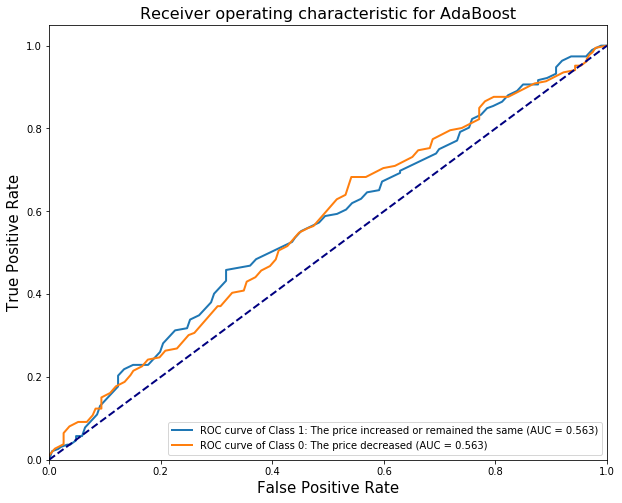

In [821]:
# At first, we re going to concatenate the training and the validation sets!
frames = [training_set, validation_set]
final_training = pd.concat(frames)

# Let's separate the input x from the output y of the full training and test sets!
training_x = final_training.loc[:,'Subjectivity':'Movement 4 days ago']
training_y = final_training.loc[:,'Label']
test_x = test_set.loc[:,'Subjectivity':'Movement 4 days ago']
test_y = test_set.loc[:,'Label']
test_y = test_y.values # In order to convert it into a numpy array

# Now, let me fill the missing values of the features using their mean!
# Change the NaN values to the mean value of that column
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    training_x[col] = training_x[col].fillna(training_x[col].mean())
    test_x[col] = test_x[col].fillna(training_x[col].mean())

# Standardize the data to have zero mean and unit variance
training_x, test_x = Preprocessing(training_x.values, test_x.values, 'standard')

model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), 
                                       n_estimators=20, learning_rate=0.001)


# First, I will create an empty list where I am going to add the prediction scores
# after each certain number of days!
indiv_scores = []
        
for i in range(0, len(test_x)):
    if (i+1) % 5 == 0:
        # Evaluate the performance on the datastream of the test set
        # and save it to the list!
        datastream_x = test_x[0:5,:]
        datastream_y = test_y[0:5]
        indiv_scores.append(model.fit(training_x, training_y).predict_proba(datastream_x))
        # Add the datastream to the training set
        training_x = np.append(training_x, test_x[0:5,:], axis=0)
        training_y = np.append(training_y, test_y[0:5], axis=0)
        # Delete the datastream from the test set
        for i in range(0, 5):
            test_x = np.delete(test_x,(0),axis=0)
            test_y = np.delete(test_y,(0),axis=0)

      
# Convert the list indiv_scores into a numpy array
y_score = np.asarray(indiv_scores)                                               
y_score = y_score.reshape(375,2)

# There are still 3 samples left on the test set!
indiv_scores = []
indiv_scores.append(model.fit(training_x, training_y).predict_proba(test_x))
indiv_scores = np.asarray(indiv_scores)
indiv_scores = indiv_scores.reshape(3,2)

# Concatenate the 375 prediction scores with the rest 3 scores!
y_score = np.concatenate((y_score,indiv_scores),axis=0)


# Redefine the test set in its initial form
test_y = test_set.loc[:,'Label']
test_y = test_y.values # In order to convert it into a numpy array

# One-Hot Encoding of the Test label
test_y_add = np.zeros((378,1))
for i in range(len(test_y)):
    if test_y[i] == 0:
        test_y_add[i] = 1
        
test_y = test_y.reshape(378,1)    
test_y = np.concatenate((test_y,test_y_add),axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = ["1: The price increased or remained the same", "0: The price decreased"]
for i in range(0,len(classes)):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(10,8))
lw = 2
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of Class {0} (AUC = {1:0.3f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver operating characteristic for AdaBoost',fontsize=16)
plt.legend(loc="lower right",fontsize=10)
plt.show()

### 4.4.1. Support Vector Machines with Linear Kernel

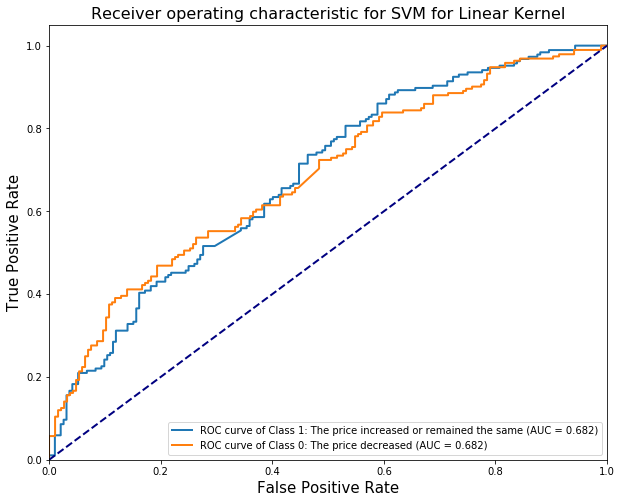

In [869]:
# At first, we re going to concatenate the training and the validation sets!
frames = [training_set, validation_set]
final_training = pd.concat(frames)

# Let's separate the input x from the output y of the full training and test sets!
training_x = final_training.loc[:,'Subjectivity':'Movement 4 days ago']
training_y = final_training.loc[:,'Label']
test_x = test_set.loc[:,'Subjectivity':'Movement 4 days ago']
test_y = test_set.loc[:,'Label']
test_y = test_y.values # In order to convert it into a numpy array

# Now, let me fill the missing values of the features using their mean!
# Change the NaN values to the mean value of that column
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    training_x[col] = training_x[col].fillna(training_x[col].mean())
    test_x[col] = test_x[col].fillna(training_x[col].mean())

# Standardize the data to have zero mean and unit variance
training_x, test_x = Preprocessing(training_x.values, test_x.values, 'standard')

model = SVC(kernel="linear", C=1000, probability=True)
model.fit(training_x, training_y)

                                           
y_score = model.predict_proba(test_x)

# One-Hot Encoding of the Test label
test_y_add = np.zeros((378,1))
for i in range(len(test_y)):
    if test_y[i] == 0:
        test_y_add[i] = 1
        
test_y = test_y.reshape(378,1)    
test_y = np.concatenate((test_y_add,test_y),axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = ["1: The price increased or remained the same", "0: The price decreased"]
for i in range(0,len(classes)):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(10,8))
lw = 2
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of Class {0} (AUC = {1:0.3f})'
             ''.format(classes[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver operating characteristic for SVM with Linear Kernel',fontsize=16)
plt.legend(loc="lower right",fontsize=10)
plt.show()

In [867]:
print(test_y)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 

In [868]:
print(y_score)

[[0.44485314 0.55514686]
 [0.49386856 0.50613144]
 [0.45457558 0.54542442]
 [0.45989072 0.54010928]
 [0.48862142 0.51137858]
 [0.5        0.5       ]
 [0.4257478  0.5742522 ]
 [0.43845528 0.56154472]
 [0.50634221 0.49365779]
 [0.43926954 0.56073046]
 [0.48338053 0.51661947]
 [0.47914917 0.52085083]
 [0.5        0.5       ]
 [0.44294865 0.55705135]
 [0.5        0.5       ]
 [0.45199245 0.54800755]
 [0.57565837 0.42434163]
 [0.40508119 0.59491881]
 [0.44510313 0.55489687]
 [0.5        0.5       ]
 [0.45087701 0.54912299]
 [0.45744048 0.54255952]
 [0.5215099  0.4784901 ]
 [0.42241389 0.57758611]
 [0.48524241 0.51475759]
 [0.4776003  0.5223997 ]
 [0.42499569 0.57500431]
 [0.48795423 0.51204577]
 [0.45620291 0.54379709]
 [0.46777101 0.53222899]
 [0.45104746 0.54895254]
 [0.46036578 0.53963422]
 [0.44739157 0.55260843]
 [0.44213043 0.55786957]
 [0.4717651  0.5282349 ]
 [0.46136882 0.53863118]
 [0.44720993 0.55279007]
 [0.45546411 0.54453589]
 [0.44998729 0.55001271]
 [0.43542031 0.56457969]
